In [2]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For model training and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Models
from sklearn.svm import SVC
import xgboost as xgb


Fetch and Load the Dataset

In [1]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas DataFrames)
X = heart_disease.data.features
y = heart_disease.data.targets

# Metadata
print(heart_disease.metadata)

# Variable information
print(heart_disease.variables)


{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [3]:
#Explore the Dataset
print("Features shape:", X.shape)
print("Targets shape:", y.shape)
print("\nFirst five rows of features:")
print(X.head())

print("\nFirst five rows of target:")
print(y.head())

Features shape: (303, 13)
Targets shape: (303, 1)

First five rows of features:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

    ca  thal  
0  0.0   6.0  
1  3.0   3.0  
2  2.0   7.0  
3  0.0   3.0  
4  0.0   3.0  

First five rows of target:
   num
0    0
1    2
2    1
3    0
4    0


In [4]:
#Data Preprocessing

# Combine features and target
df = pd.concat([X, y], axis=1)
# Assign column names
column_names = [
    'age',       # 3
    'sex',       # 4
    'cp',        # 9
    'trestbps',  # 10
    'chol',      # 12
    'fbs',       # 16
    'restecg',   # 19
    'thalach',   # 32
    'exang',     # 38
    'oldpeak',   # 40
    'slope',     # 41
    'ca',        # 44
    'thal',      # 51
    'num'        # 58 (the predicted attribute)
]

df.columns = column_names

#Handle Missing Values
# Replace missing values represented as '?' or empty strings with NaN
df.replace(['?', ''], np.nan, inplace=True)

# Convert columns to appropriate data types
df = df.apply(pd.to_numeric, errors='coerce')

# Check for missing values
print(df.isnull().sum())

# Fill missing numerical values with median
for col in ['ca', 'thal', 'oldpeak', 'slope']:
    df[col].fillna(df[col].median(), inplace=True)

# Simplify 'num' to binary classification
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True)

# Convert 'ca' and 'thal' to integer type before encoding
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

# List of categorical columns
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']

# One-Hot Encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


Feature Scaling
Scale numerical features for SVM (since SVM is sensitive to feature scaling).

In [5]:
# List of numerical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [6]:
# Features and target variable
X = df.drop('target', axis=1)
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Support Vector Machine (SVM)
I use GridSearchCV to find the best hyperparameters for the SVM model.

In [7]:
from sklearn.svm import SVC

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly']
}

# Initialize the model
svm = SVC()

# Initialize GridSearchCV
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}


In [8]:
# Predict on the test set
y_pred_svm = grid_search.predict(X_test)

# Evaluation metrics
print("SVM Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy Score:", accuracy_score(y_test, y_pred_svm))


SVM Model Evaluation:
Confusion Matrix:
[[27  6]
 [ 2 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

Accuracy Score: 0.8688524590163934


XGBoost Model

In [19]:
from xgboost import XGBClassifier

# Initialize the model with desired parameters
xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_clf.predict(X_test)

# If you need probabilities:
y_pred_prob = xgb_clf.predict_proba(X_test)[:, 1]


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("XGBoost Model Evaluation:")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy Score:", accuracy_score(y_test, y_pred_xgb))


XGBoost Model Evaluation:
Confusion Matrix:
[[28  5]
 [ 1 27]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.90        33
           1       0.84      0.96      0.90        28

    accuracy                           0.90        61
   macro avg       0.90      0.91      0.90        61
weighted avg       0.91      0.90      0.90        61

Accuracy Score: 0.9016393442622951


Compare Model Performance

In [22]:
# SVM Accuracy
svm_accuracy = accuracy_score(y_test, y_pred_svm)

# XGBoost Accuracy
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
print(f"XGBoost Accuracy: {xgb_accuracy * 100:.2f}%")


SVM Accuracy: 86.89%
XGBoost Accuracy: 90.16%


Visualizing the Performance of SVM and XGBoost Models on the Heart Disease Dataset

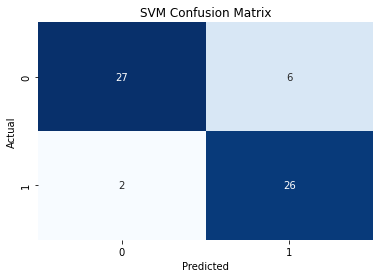

In [23]:
#Confusion Matrix for SVM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


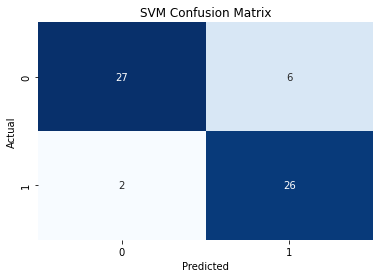

In [24]:
#Confusion Matrix for SVM
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


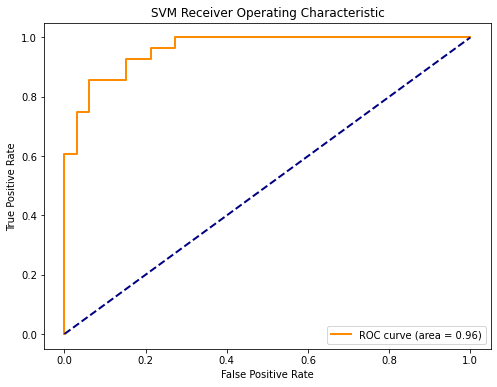

In [25]:
#ROC Curve for SVM
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_pred_proba_svm = grid_search.decision_function(X_test)

# Compute ROC curve and ROC area
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('SVM Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#ROC Curve for XGBoost
# Predict probabilities for the positive class
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('XGBoost Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
